# AI 1, Walid OUBRAIM
## Glioma Grading: Clinical and Mutation Features
The task is to train a classifier to predict Glioma grade using the provided dataset

### Data and Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

In [2]:
dataset.head()

,sample_id,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,LGG,Male,51 years 108 days,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,2,LGG,Male,38 years 261 days,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,3,LGG,Male,35 years 62 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,4,LGG,Female,32 years 283 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,5,LGG,Male,31 years 187 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [3]:
# Representing the dimensionality of the DataFrame
print("Rows, Columns :",dataset.shape)

# Check if the dataset has null values
has_nan = dataset.isnull().values.any()
if has_nan:
    print("The dataset contains NaN values.")
else:
    print("The dataset does not contain any NaN values.")

# Display columns with number of null values
missing_values = dataset.isnull().sum()
print(missing_values)

Rows, Columns : (846, 25)
The dataset does not contain any NaN values.
sample_id           0
Grade               0
Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
dtype: int64


In [4]:
# Display unique values to see if there is some 'special' values
for column in dataset.columns:
    print(f"{column}: {dataset[column].unique()}")

sample_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244

We can see that :
- The columns "Gender", "Age_at_diagnosis" and "Race" has '--' values
- The column Race has 'not reported' values
- The column "Age_at_diagnosis" has a value without 'days'

To deal with 'empty' values ('--', 'not reported'), we can either remove the rows or/and do imputation (impute missing values with the most frequent value).
We will also create a function to transform the Age_at_diagnosis column into numericals values.

In [5]:
# Extract the numerical value from the age column
def extract_age(age):
    if 'years' in age and 'days' in age:
        splitting = age.split(' ')
        years = int(splitting[0])
        days = int(splitting[2])
        return years + days/365
    elif 'years' in age:
        years = int(age.split(' ')[0])
        return years
    else:
        return None

# Drop rows that contain '--' for Gender and Age
dataset = dataset.drop(dataset[dataset['Gender'] == '--'].index)
dataset = dataset.drop(dataset[dataset['Age_at_diagnosis'] == '--'].index)
# Apply the function on the Age column
dataset['Age_at_diagnosis'] = dataset['Age_at_diagnosis'].apply(extract_age)

# Impute "not reported" values with the most frequent value
dataset['Race'] = dataset['Race'].replace('not reported',np.nan)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
dataset[['Race']] = imputer.fit_transform(dataset[['Race']])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


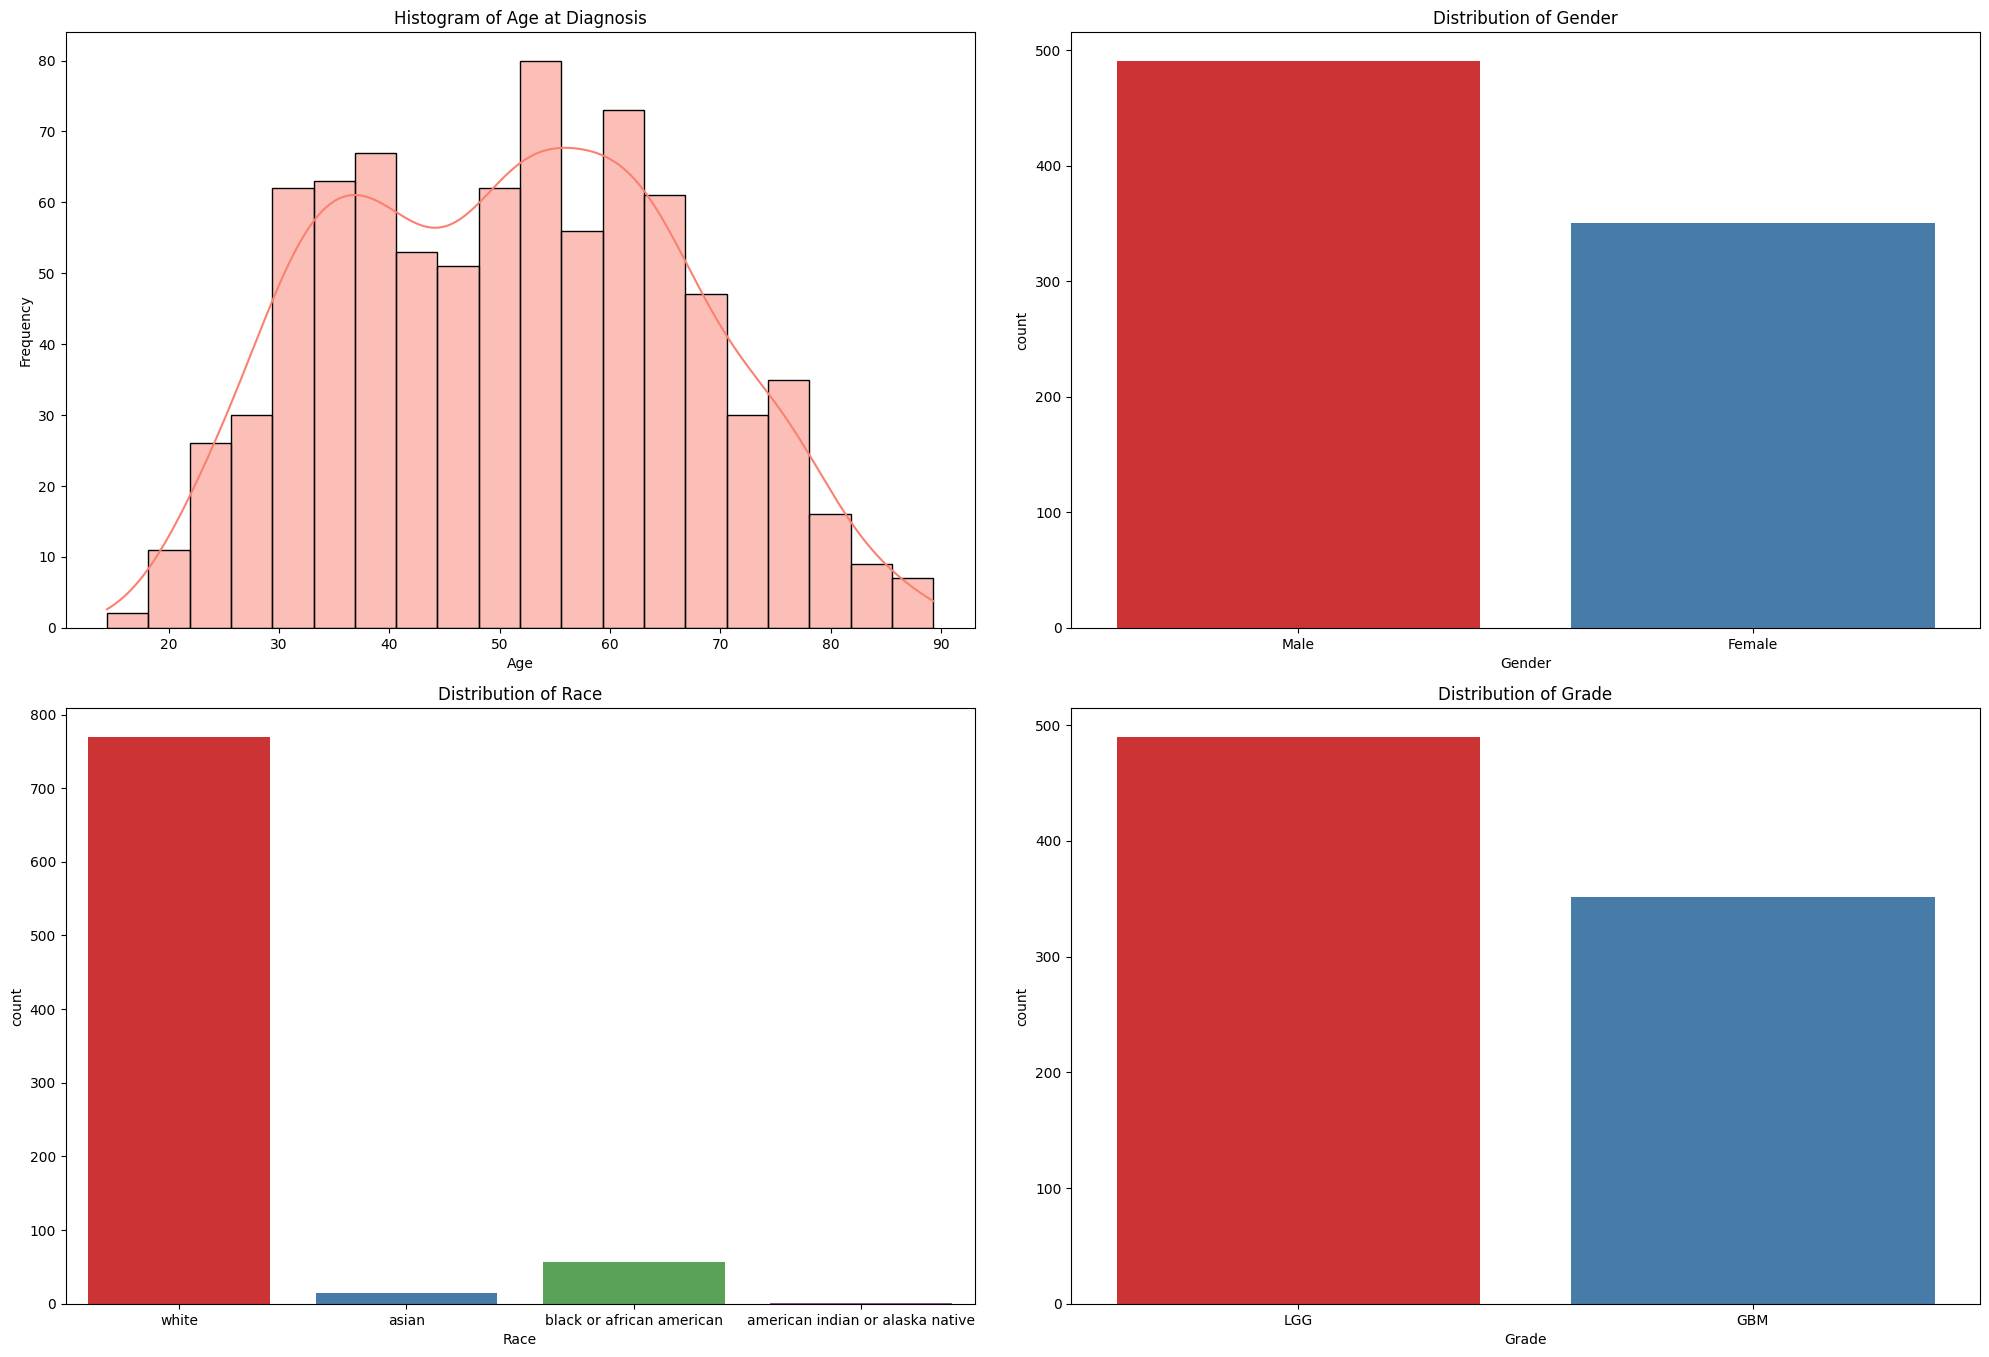

In [6]:
import seaborn as sns

plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
sns.histplot(dataset['Age_at_diagnosis'], bins=20, kde=True, color='salmon')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age at Diagnosis')

plt.subplot(3, 2, 2)
sns.countplot(x='Gender', data=dataset, palette='Set1')
plt.xlabel('Gender')
plt.xlabel('Gender')
plt.title('Distribution of Gender')

plt.subplot(3, 2, 3)
sns.countplot(x='Race', data=dataset, palette='Set1')
plt.xlabel('Race')
plt.title('Distribution of Race')

plt.subplot(3, 2, 4)
sns.countplot(x='Grade', data=dataset, palette='Set1')
plt.xlabel('Grade')
plt.title('Distribution of Grade')


plt.tight_layout()
plt.show()

The dependant variable is : ['Grade']
The categorials columns are :  the 20 genes, ['Gender'], ['Race']
The continious columns are : ['Age_at_diagnosis']

In [7]:
# Independant variable
X = dataset.iloc[:, 2:-1].values
print(X)
# Dependant variable
y = dataset.iloc[:, 1].values
#print(y)

[['Male' 51.295890410958904 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 38.71506849315068 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 35.16986301369863 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ...
 ['Female' 77.4876712328767 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 63.33150684931507 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 76.6054794520548 'black or african american' ... 'NOT_MUTATED'
  'NOT_MUTATED' 'NOT_MUTATED']]


In [8]:
# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
#print(y)

In [9]:
# Encoding the Independent Variable with OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print(X[0])

[0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0
 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0
 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 51.295890410958904]


### Data Splitting

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train)
#print(y_train)
#print(X_test)
#print(y_test)

[[0.0 1.0 0.0 ... 0.0 1.0 35.16986301369863]
 [0.0 1.0 0.0 ... 0.0 1.0 61.30684931506849]
 [1.0 0.0 0.0 ... 0.0 1.0 44.57260273972603]
 ...
 [0.0 1.0 0.0 ... 0.0 1.0 78.25479452054795]
 [1.0 0.0 0.0 ... 0.0 1.0 52.652054794520545]
 [0.0 1.0 0.0 ... 0.0 1.0 48.5013698630137]]


### Apply feature scaling

In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.97665231]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.69156567]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
  -0.37651351]
 ...
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   1.77328437]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
   0.13916519]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.12575622]]
[[-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.26751655]
 [-0.85815739  0.85815739 -0.03860457 ...  6.61815684 -6.61815684
  -0.62499755]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
  -0.12593109]
 ...
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
   1.19657757]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.35494936]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.43159618]]


### Model Selection with Cross Validation and Hyperparameter Tuning with GridSearchCV


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define parameter grids for each algorithm
param_grid_lr = {'C': [0.1, 0.25, 0.5, 1, 5], 'penalty': ['l2','l1']}
param_grid_dt = {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]}
param_grid_rf = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
param_grid_svm = {'C': [0.1, 0.25, 0.5, 1, 5], 'kernel': ['linear', 'rbf'],'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_lr,scoring = 'accuracy', n_jobs = -1, cv=10)
grid_lr.fit(X_train, y_train)

# Decision Tree
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt,scoring = 'accuracy',  n_jobs = -1, cv=10)
grid_dt.fit(X_train, y_train)

# Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf,scoring = 'accuracy', n_jobs = -1, cv=10)
grid_rf.fit(X_train, y_train)

# Support Vector Machine
grid_svm = GridSearchCV(SVC(), param_grid_svm,scoring = 'accuracy', cv=10, n_jobs = -1)
grid_svm.fit(X_train, y_train)

# Print best parameters and best scores for each algorithm
print("Logistic Regression - Best params:", grid_lr.best_params_, "Best score:", grid_lr.best_score_)
print("Decision Tree - Best params:", grid_dt.best_params_, "Best score:", grid_dt.best_score_)
print("Random Forest - Best params:", grid_rf.best_params_, "Best score:", grid_rf.best_score_)
print("Support Vector Machine - Best params:", grid_svm.best_params_, "Best score:", grid_svm.best_score_)

Logistic Regression - Best params: {'C': 1, 'penalty': 'l1'} Best score: 0.8750438981562774
Decision Tree - Best params: {'max_depth': 3, 'min_samples_split': 2} Best score: 0.8602063213345039
Random Forest - Best params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200} Best score: 0.8721027216856893
Support Vector Machine - Best params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'} Best score: 0.8735952589991219


We can now train the model with the best parameters : Logistic Regression with C = 1 and penalty = l1

In [13]:
best_classifier = grid_lr.best_estimator_
best_classifier.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

### Predicting the Test set results

In [14]:
y_pred = best_classifier.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)
print(np.concatenate((y_pred_labels.reshape(len(y_pred),1), y_test_labels.reshape(len(y_test),1)),1))


[['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'LGG']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['LGG' 'LGG']
 ['LGG' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'LGG']
 ['GBM' 'LGG']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['GBM' 'GBM']
 ['LGG' 'L

### Model Evaluation 

In [15]:
# Making the Confusion Matrix and Accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy score",accuracy_score(y_test, y_pred))
# F1 Score
print("F1 score :",f1_score(y_test, y_pred))


tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)
print("specificity",specificity)
# Sensitivity
sensitivity = tp / (tp + fn)
print("sensitivity",sensitivity)

Confusion Matrix:
[[64  8]
 [15 82]]
Accuracy score 0.863905325443787
F1 score : 0.8770053475935828
specificity 0.8888888888888888
sensitivity 0.845360824742268


### Plot precision-recall curves and ROC curves for all trained classifiers.

#### Logistic Regression

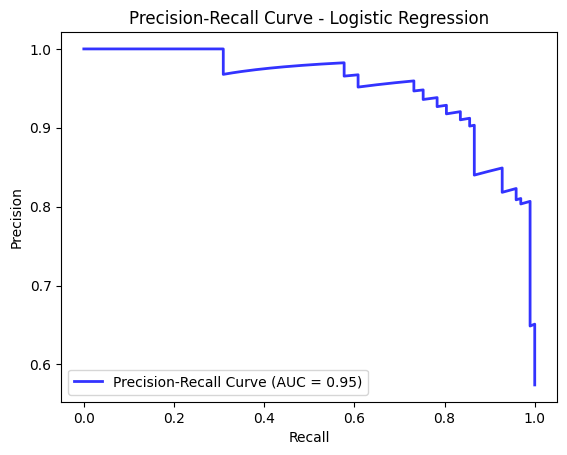

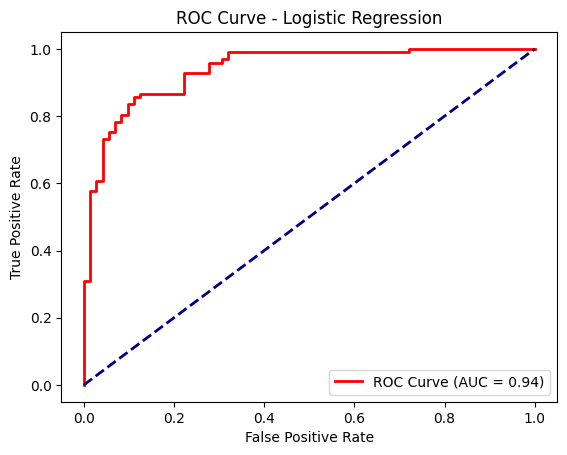

In [16]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Compute predicted probabilities
y_prob = best_classifier.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='b', alpha=0.8, lw=2, label='Precision-Recall Curve (AUC = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


#### Decision Tree

In [17]:
best_dt = grid_dt.best_estimator_
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

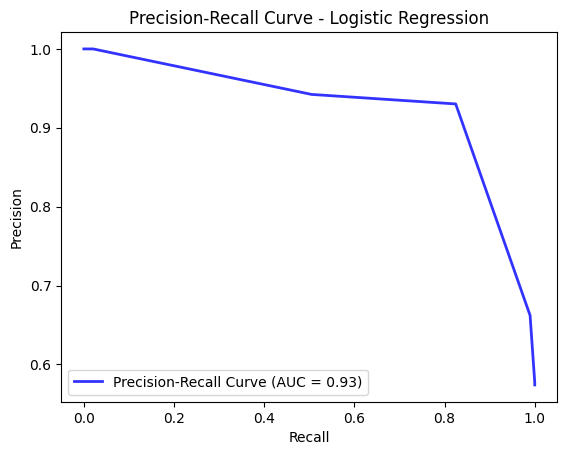

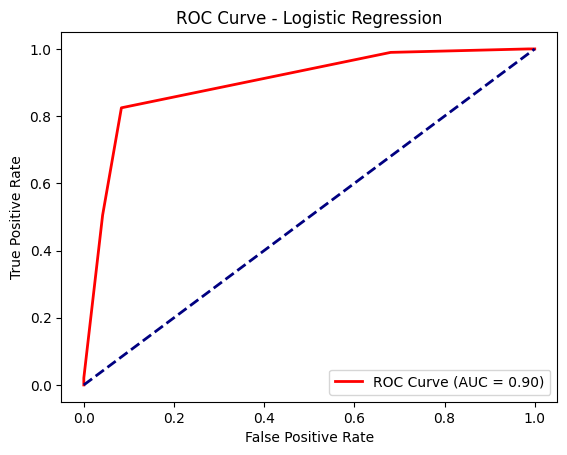

In [18]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt


# Compute predicted probabilities
y_prob = best_dt.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='b', alpha=0.8, lw=2, label='Precision-Recall Curve (AUC = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

### Feature importance 

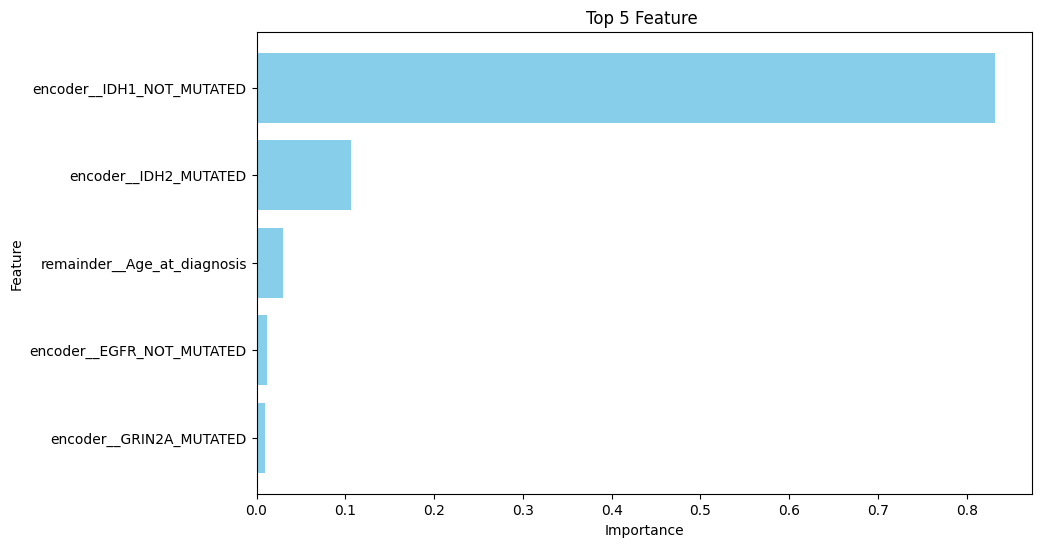

In [19]:
# Get feature importances from the trained decision tree model
feature_importances = best_dt.feature_importances_

# Match feature importances with column names
column_names = np.array(ct.get_feature_names_out(input_features=dataset.columns[2:-1]))
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature ')
plt.gca().invert_yaxis()  
plt.show()


It seems that the genes IDH1 and IDH2 are the two features that contribute the most to Glioma grade prediction